<a href="https://colab.research.google.com/github/natdebandi/hate_speech_ar/blob/main/1_finetuning_BETO_multiclass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP final - reconocimiento de discursos discriminatorios en Twitter

##(1.2) Finetuning de BETO para múltiples etiquetas

Natalia Dedandi

Este cuaderno entrena un clasificador BETO (variante en españl del modelo pre-entrenado BERT). Para ello se basa en el siguiente ejemplo:

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

Se modifica de este ejemplo el modelo que se utiliza, haciendo uso del modelo preentrenado: dccuchile/bert-base-spanish-wwm-uncased

https://github.com/dccuchile/beto?tab=readme-ov-file




In [1]:
!pip install datasets seaborn
! pip install -U accelerate
! pip install -U transformers

  Using cached accelerate-0.33.0-py3-none-any.whl.metadata (18 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata 

In [2]:
# no lograba bajar el dataset porque
# me fallaba bajar archivos de hugginface y tenia que actualizar esto (JUAN MA me ayudo)
#pip install -U datasets

In [26]:
from datasets import load_dataset
import pandas as pd
from datetime import datetime, timedelta
from tqdm.auto import tqdm
from collections import Counter

(1) Dataset de etiquetado

https://huggingface.co/datasets/piuba-bigdata/contextualized_hate_speech

Este es el dataset original de etiquetado. Contiene los siguientes campos:

ID : identificador

TITLE: título de la noticia

TEXT: texto del tweet del comentario al Tweet original

CONTEXT: tweet original

HATEFUL: 1 hateful, 0 not hateful

BODY: texto de la noticia

CALLS: si se realizó o no un llamado a la acción

WOMEN: discriminación hacia mujeres

LGBTI: discriminación hacia grupos LGBTI

RACISM: discriminación asociada a racismo

CLASS: discriminación vinculada a pobreza, villas

POLITICS: odio o violencia vinculada a las ideas políticas

DISABLED: discriminación a las personas con discapacidad

APPEARENCE: discriminación en base al aspecto físico (incluye especialmente la gordofobia)

CRIMINAL: discriminación hacia personas en el sistema penal o similares



In [27]:
# para ver las versiones de las librerias
#pip freeze

In [28]:
from huggingface_hub import notebook_login
notebook_login()

In [29]:
from datasets import load_dataset

ds1 = load_dataset("piuba-bigdata/contextualized_hate_speech")



In [30]:
ds1

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 36420
    })
    test: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 11343
    })
    dev: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 9106
    })
})

In [8]:
##Esto era para levantarlo desde parquet cuando no pude hacerlo con HUGGINFACE
## cargo  train, test y dev por separado
##ds1_train=pd.read_parquet('train/train-00000-of-00001.parquet', engine='pyarrow')
###ds1_train

El dataset 1 contiene 56869 tw etiquetados.
El dataset se dividió en 36420 de train, test:11343 y vaLidacion:9106

In [32]:
ds1["train"]

Dataset({
    features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
    num_rows: 36420
})

In [33]:
#example1= ds1_train[30355]

example1= ds1["train"][21255]
example1

{'id': 368484,
 'title': 'Video indignante: piba violó la cuarentena y viajó en el baúl de un taxi para ver a un chico',
 'text': '@usuario Estilo Aníbal Fernández',
 'context_tweet': 'Video indignante: piba violó la cuarentena y viajó en el baúl de un taxi para ver a un chico #LogróPasarControlPolicial #EnPuentePueyrredón #FilmóTodo #LoPublicóEnRedesSociales #ComoSiFueraUnaHazaña #Tonta #PoneVidasEnRiesgo #TodoPorUnChongo #MiráEsoChacal https://t.co/ZNlLNNJGaj',
 'HATEFUL': 0,
 'body': 'Si eran pocos los irresponsables que violaban la cuarentena dispuesta por el Gobierno nacional semanas atrás, ahora apareció una joven para engrosar la lista de hechos insólitos que avergüenzan a la sociedad. Es que la chica de unos 25 años cruzó el control policial impuesto en el acceso a Capital Federal desde el partido de Avellaneda, adentro del baúl de un taxi, y para consagrar su hazaña, grabó un video que subió a las redes sociales en el momento del hecho.\n\nEl hecho tuvo lugar en la madrugada d

In [34]:
import torch
torch.cuda.is_available()

True

### 1. pre-process data

In [35]:
 ds1['train'][0]

{'id': 343726,
 'title': 'Video: salió de la cárcel por el coronavirus y murió de un tiro el mismo día al festejar su libertad',
 'text': '@usuario Uno menos',
 'context_tweet': 'Video: salió de la cárcel por el coronavirus y murió de un tiro el mismo día al festejar su libertad https://t.co/UrJGRAdEvD',
 'HATEFUL': 1,
 'body': 'Un hombre de 46 años, que cumplía una condena en prisión y fue puesto en libertad por el coronavirus, murió el mismo día que dejó la cárcel baleado por un primo, durante los "festejos" por dejar la prisión.\n\nSari Salem Wardat, de 46 años, recibió un disparo desde atrás en un aparente accidente mientras caminaba hacia miembros de la familia y vecinos que se habían reunido para darle la bienvenida a su casa, en Jordania.\n\nUn video que circuló en las redes sociales \u200bmuestra a Sari llegando a su casa en un auto azul rodeado de tiros de "celebración". El primo se acerca de inmediato a Sari, que sostiene una pistola y la apunta hacia el cielo.\n\nEl detenido

## PREPROCESAMIENTO


Preparo los datasets solo con las etiquetas que necesito para la multiclasificación.

In [36]:
ds_hate=ds1.select_columns(["id","text","HATEFUL","CALLS","WOMEN","LGBTI","RACISM","CLASS","POLITICS","DISABLED","APPEARANCE","CRIMINAL"])
ds_hate

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 36420
    })
    test: Dataset({
        features: ['id', 'text', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 11343
    })
    dev: Dataset({
        features: ['id', 'text', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 9106
    })
})

Transformo las etiquetas originales en labels


In [37]:

labels = [label for label in ds_hate['train'].features.keys() if label not in ['id', 'text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['HATEFUL',
 'CALLS',
 'WOMEN',
 'LGBTI',
 'RACISM',
 'CLASS',
 'POLITICS',
 'DISABLED',
 'APPEARANCE',
 'CRIMINAL']

La siguiente función va a preparar los datos. Aplica el tokenizado usando la función auto-tokenizer del modelo BETO y y construye una matriz de labels

In [38]:

from transformers import AutoTokenizer
import numpy as np

#uso este tokenizer
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")


#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["text"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding

Aplico la funcion al dataset de train

In [39]:
ds_hate

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 36420
    })
    test: Dataset({
        features: ['id', 'text', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 11343
    })
    dev: Dataset({
        features: ['id', 'text', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 9106
    })
})

In [40]:
encoded_dataset = ds_hate.map(preprocess_data, batched=True, remove_columns=ds_hate['train'].column_names)

Map:   0%|          | 0/11343 [00:00<?, ? examples/s]

Pruebo el encoded

In [41]:
example =  encoded_dataset['train'][7]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [42]:
tokenizer.decode(example['input_ids'])

'[CLS] @ usuario lastima que no murio... necesitamos unos cuantos martires para que los zurdos de mierda dejen de sobarle los huevos a la estatua de peron... sucios peronchitos... y los macristas de mierda no se quedan atras. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [43]:
example['labels']

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

In [44]:

[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['HATEFUL', 'POLITICS']

In [45]:

encoded_dataset.set_format("torch")

## Defino el modelo y entreno

In [46]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparo los parámetros para ele entrenamiento

F1 score is a machine learning evaluation metric that measures a model’s accuracy. It combines the precision and recall scores of a model.

The accuracy metric computes how many times a model made a correct prediction across the entire dataset. This can be a reliable metric only if the dataset is class-balanced; that is, each class of the dataset has the same number of samples.

In [47]:
batch_size = 16
metric_name = "f1"

In [48]:

##en este caso utilizo una combinacion de las opciones de ambos ejemplos para mejorar el performance

from transformers import TrainingArguments, Trainer

repo_name = "beto_hate_speech_ar_multiclasif"

args = TrainingArguments(
	 output_dir=repo_name,
   evaluation_strategy = "epoch",
   learning_rate=2e-5,
   per_device_train_batch_size=batch_size,
   per_device_eval_batch_size=batch_size,
   num_train_epochs=5,
   weight_decay=0.01,
   metric_for_best_model=metric_name,
   load_best_model_at_end=True,
   save_strategy="epoch",
   push_to_hub=True,
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Funcion para computar las metricas


In [52]:
##FUNCION PARA COMPUTAR LAS METRIcas
from transformers import EvalPrediction
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import torch

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    y_true = labels


    # Calculate macro-averaged metrics
    f1_macro = f1_score(y_true,y_pred,average='macro')
    precision_macro = precision_score(y_true,y_pred,average='macro')
    recall_macro = recall_score(y_true,y_pred,average='macro')
    accuracy_macro = accuracy_score(y_true,y_pred)
    AUC_macro = roc_auc_score(y_true,y_pred,average='macro')

    metrics =  { "precision": precision_macro, "recall": recall_macro, "accuracy": accuracy_macro,"f1": f1_macro, "auc":AUC_macro}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result



Revision de parametros de TRAINER
https://huggingface.co/docs/transformers/main_classes/trainer

Definicipon de parametros
https://huggingface.co/docs/transformers/v4.41.3/en/main_classes/trainer#transformers.TrainingArguments



In [53]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [54]:
# Train pre-trained model
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,Accuracy,F1,Auc
1,0.049800,0.097599,0.691494,0.421204,0.859208,0.500462,0.706008
2,0.052000,0.101864,0.638693,0.463895,0.860795,0.528571,0.726559
3,0.033300,0.109289,0.624013,0.471893,0.860707,0.533731,0.730563
4,0.022400,0.118928,0.620451,0.476171,0.857181,0.534294,0.732367
5,0.015500,0.122929,0.615603,0.471043,0.859208,0.531060,0.729980


TrainOutput(global_step=11385, training_loss=0.03667044650058135, metrics={'train_runtime': 4453.223, 'train_samples_per_second': 40.892, 'train_steps_per_second': 2.557, 'total_flos': 1.19789911696896e+16, 'train_loss': 0.03667044650058135, 'epoch': 5.0})

In [55]:
trainer.evaluate()

{'eval_loss': 0.1189277172088623,
 'eval_precision': 0.6204512863626905,
 'eval_recall': 0.4761712609974168,
 'eval_accuracy': 0.8571806400423169,
 'eval_f1': 0.5342940688758071,
 'eval_auc': 0.7323665632202255,
 'eval_runtime': 80.9271,
 'eval_samples_per_second': 140.163,
 'eval_steps_per_second': 8.761,
 'epoch': 5.0}

In [56]:
# compute predictions on test set
predic = trainer.predict(encoded_dataset["test"])


In [59]:
# prompt: create a dataframe with the result of predicted values from trainer  into actual label names and merge with the original eval_dataset

# format predictions to actual label names
preds = predic.predictions
probs = 1 / (1 + np.exp(-preds))  # Sigmoid to get probabilities
threshold = 0.5  # Adjust threshold as needed
predicted_labels = (probs > threshold).astype(int)

# Create dataframe with predicted labels
predicted_df = pd.DataFrame(predicted_labels, columns=labels)

# Map label indices to label names
predicted_df = predicted_df.rename(columns=id2label)

# Merge predicted labels with original eval_dataset
#eval_df = encoded_dataset["test"].to_pandas()
#result_df = pd.concat([eval_df, predicted_df], axis=1)


In [66]:
eval_df=ds_hate["test"].to_pandas()
eval_df

,id,text,HATEFUL,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL
0,397703,@usuario Ojalá se funda y cague de hambre,0,0,0,0,0,0,0,0,0,0
1,397704,@usuario Faltó que se enganchó al hijo de sofo...,1,0,1,0,0,0,0,0,0,0
2,397705,"@usuario y bue, que le vaya a llorar a Cristin...",0,0,0,0,0,0,0,0,0,0
3,397706,@usuario @usuario Jodete. Macri te hizo conoce...,0,0,0,0,0,0,0,0,0,0
4,397707,"@usuario Que se joda, es su gobierno el que el...",0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11338,361071,@usuario Con esa varita q no rompe un plato ni...,0,0,0,0,0,0,0,0,0,0
11339,361072,@usuario No las entiendo a estas pelotudas. So...,1,0,1,0,0,0,0,0,0,0
11340,361073,@usuario Lo mató por qué es macho!,0,0,0,0,0,0,0,0,0,0
11341,361074,@usuario Cuando sos asesina tenés que hacerte ...,0,0,0,0,0,0,0,0,0,0


In [68]:
# prompt: merge predicted_df and eval_df with the index

result_df = pd.merge(eval_df, predicted_df, left_index=True, right_index=True)


In [70]:
result_df

,id,text,HATEFUL_x,CALLS_x,WOMEN_x,LGBTI_x,RACISM_x,CLASS_x,POLITICS_x,DISABLED_x,...,HATEFUL_y,CALLS_y,WOMEN_y,LGBTI_y,RACISM_y,CLASS_y,POLITICS_y,DISABLED_y,APPEARANCE_y,CRIMINAL_y
0,397703,@usuario Ojalá se funda y cague de hambre,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,397704,@usuario Faltó que se enganchó al hijo de sofo...,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,397705,"@usuario y bue, que le vaya a llorar a Cristin...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,397706,@usuario @usuario Jodete. Macri te hizo conoce...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,397707,"@usuario Que se joda, es su gobierno el que el...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11338,361071,@usuario Con esa varita q no rompe un plato ni...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11339,361072,@usuario No las entiendo a estas pelotudas. So...,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11340,361073,@usuario Lo mató por qué es macho!,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
11341,361074,@usuario Cuando sos asesina tenés que hacerte ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


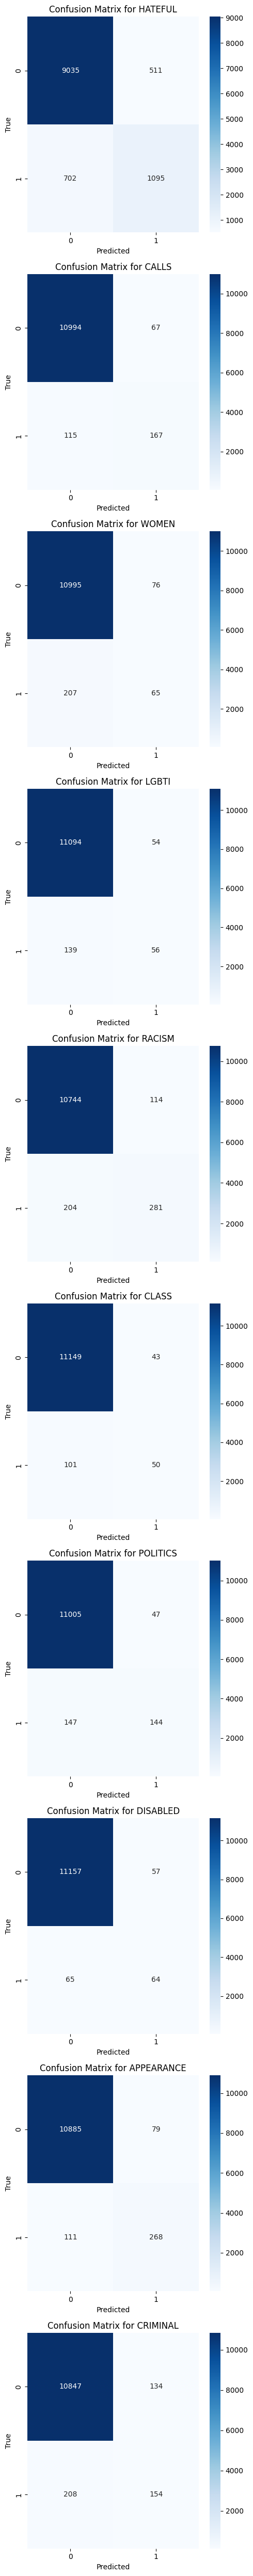

In [73]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features to plot
features = ['HATEFUL', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL']

# Create a grid of confusion matrices
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(5, 5 * len(features)))

for i, feature in enumerate(features):
    # Calculate the confusion matrix
    cm = confusion_matrix(result_df[feature+ '_x'], result_df[feature + '_y'])

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix for {feature}')

plt.tight_layout()
plt.show()

In [72]:
# prompt: calculate accuracy, precision, recall and F1 for ecah features  'HATEFUL_x', 'CALLS_x',  'WOMEN_x', 'LGBTI_x', 'RACISM_x', 'CLASS_x', 'POLITICS_x', 'DISABLED_x', 'APPEARANCE_x', 'CRIMINAL_x' in result_df comparing the  the same column that have the text '_y'.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics=[]
# Iterate over each feature and calculate metrics
for feature in ['HATEFUL', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL']:
    y_true = result_df[feature + '_x']
    y_pred = result_df[feature + '_y']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    metrics.append([feature,accuracy,precision,recall,f1,auc])

    print(f"Metrics for {feature}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  AUC: {auc:.4f}")
    print()

Metrics for HATEFUL:
  Accuracy: 0.8931
  Precision: 0.6818
  Recall: 0.6093
  F1-score: 0.6435
  AUC: 0.7779

Metrics for CALLS:
  Accuracy: 0.9840
  Precision: 0.7137
  Recall: 0.5922
  F1-score: 0.6473
  AUC: 0.7931

Metrics for WOMEN:
  Accuracy: 0.9751
  Precision: 0.4610
  Recall: 0.2390
  F1-score: 0.3148
  AUC: 0.6161

Metrics for LGBTI:
  Accuracy: 0.9830
  Precision: 0.5091
  Recall: 0.2872
  F1-score: 0.3672
  AUC: 0.6412

Metrics for RACISM:
  Accuracy: 0.9720
  Precision: 0.7114
  Recall: 0.5794
  F1-score: 0.6386
  AUC: 0.7844

Metrics for CLASS:
  Accuracy: 0.9873
  Precision: 0.5376
  Recall: 0.3311
  F1-score: 0.4098
  AUC: 0.6636

Metrics for POLITICS:
  Accuracy: 0.9829
  Precision: 0.7539
  Recall: 0.4948
  F1-score: 0.5975
  AUC: 0.7453

Metrics for DISABLED:
  Accuracy: 0.9892
  Precision: 0.5289
  Recall: 0.4961
  F1-score: 0.5120
  AUC: 0.7455

Metrics for APPEARANCE:
  Accuracy: 0.9832
  Precision: 0.7723
  Recall: 0.7071
  F1-score: 0.7383
  AUC: 0.8500

Metri

Voy a probar el modelo entrenado y guardado

In [ ]:
#text = "I'm happy I can finally train a model for multi-label classification"


data = ["hay que matarlos a todos", "Vamos a la plaza a marchar"]
specific_model = pipeline(model="natdebandi/beto_hate_speech_ar_multiclasif")
specific_model(data)


#encoding = tokenizer(data, return_tensors="pt")
#encoding = {k: v.to(trainer.specific_model.device) for k,v in encoding.items()}

#outputs = trainer.specific_model(**encoding)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'CALLS', 'score': 0.9833989143371582},
 {'label': 'HATEFUL', 'score': 0.0034015194978564978}]

In [ ]:
from transformers import pipeline
data = ["hay que matarlos a todos", "Vamos a la plaza a marchar"]
specific_model = pipeline(model="natdebandi/beto-hate_speech_ar_bin")
specific_model(data)

config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/735k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_1', 'score': 0.951015830039978},
 {'label': 'LABEL_0', 'score': 0.9810741543769836}]

In [ ]:
data = ["hay que matarlos a todos"]


pipe("sos un hijo de puta")

[{'label': 'LABEL_0', 'score': 0.967201828956604}]